In [1]:
import tonic
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np

In [2]:
img_size = 128 # NMNIST 34, DVSGesture 128
time = 20
duration = 25_000 # 25_000 50_000 100_000 10_000
clipping = 2
extra_train_dataset = 0
transform = tonic.transforms.Compose([
    # tonic.transforms.MergePolarities(), #polarity 없애기
    # tonic.transforms.CropTime(max=6_000_000), 
    tonic.transforms.CropTime(max=(100_000 + (2_300_000//(extra_train_dataset+1))*extra_train_dataset + duration*(time+1))), 
    tonic.transforms.CropTime(min=(100_000 + (2_300_000//(extra_train_dataset+1))*extra_train_dataset)), 
    # tonic.transforms.Denoise(filter_time=10_000), # 10_000 # 낮을수록 더 많이 거름
    tonic.transforms.Downsample(spatial_factor=img_size/tonic.datasets.DVSGesture.sensor_size[0]),
    tonic.transforms.ToFrame(
        # sensor_size=tonic.datasets.DVSGesture.sensor_size,
        sensor_size=(img_size,img_size,2),
        time_window=duration, 
        include_incomplete=False),
        
])

train_dataset = tonic.datasets.DVSGesture('/data2', train=True, transform=transform, clipping = clipping, time = time)
test_dataset = tonic.datasets.DVSGesture('/data2', train=False, transform=transform, clipping = clipping, time = time)

In [3]:
# img_size = 34 # NMNIST 34, DVSGesture 128
# time = 20
# duration = 1_000
# clipping = 1
# transform = tonic.transforms.Compose([
#     # tonic.transforms.MergePolarities(), #polarity 없애기
#     # tonic.transforms.Denoise(filter_time=10_000),
#     tonic.transforms.CropTime(max=320_000), 
#     tonic.transforms.CropTime(min=10_000), 
#     tonic.transforms.Downsample(spatial_factor=img_size/tonic.datasets.NMNIST.sensor_size[0]),
#     tonic.transforms.ToFrame(
#         # sensor_size=tonic.datasets.DVSGesture.sensor_size,
#         sensor_size=(img_size,img_size,2),
#         time_window=duration, 
#         include_incomplete=False),
        
# ])

# train_dataset = tonic.datasets.NMNIST('/data2', train=True, transform=transform, clipping = clipping, time = time)
# test_dataset = tonic.datasets.NMNIST('/data2', train=False, transform=transform, clipping = clipping, time = time)

In [4]:
print(tonic.datasets.NMNIST.sensor_size)
print(tonic.datasets.DVSGesture.sensor_size)

(34, 34, 2)
(128, 128, 2)


In [5]:
print(train_dataset.__len__())
print(test_dataset.__len__())

1077
264


In [6]:


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True, num_workers=2, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle = False, num_workers=2, drop_last=False)


In [7]:
# # Initialize counters
# train_label_10_count = 0
# train_label_not_10_count = 0
# test_label_10_count = 0
# test_label_not_10_count = 0

# # Iterate over train_loader
# for data, labels in train_loader:
#     train_label_10_count += (labels == 10).sum().item()
#     train_label_not_10_count += (labels != 10).sum().item()

# # Iterate over test_loader
# for data, labels in test_loader:
#     test_label_10_count += (labels == 10).sum().item()
#     test_label_not_10_count += (labels != 10).sum().item()

# # Print the results
# print(f"Train Loader - Label 10 Count: {train_label_10_count}, Label Not 10 Count: {train_label_not_10_count}")
# print(f"Test Loader - Label 10 Count: {test_label_10_count}, Label Not 10 Count: {test_label_not_10_count}")

# # gesture 
# # Train Loader - Label 10 Count: 98, Label Not 10 Count: 979
# # Test Loader - Label 10 Count: 24, Label Not 10 Count: 240


In [8]:

img, label = next(iter(test_loader))
print(img.shape, label.shape)   
print(label)


torch.Size([64, 20, 2, 128, 128]) torch.Size([64])
tensor([ 3,  5, 10,  6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,
         4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,
         6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,  4,  9,  0,
         1,  3,  5, 10,  6,  7,  2,  8,  4,  9])


In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
def dvs_visualization(inputs, labels, TIME, BATCH, my_seed, duration, clipping):
    seed_assign(seed = my_seed)
    TIME = TIME if TIME <= 20 else 20
    what_input = random.randint(0, BATCH - 1)
    # if inputs.size(4)==128:
    #     timestep, batch_size, in_c, h, w = inputs.shape
    #     maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    #     inputs = maxpool(inputs.reshape(timestep*batch_size, in_c, h, w))
    #     inputs = maxpool(inputs)
    #     inputs = maxpool(inputs).reshape(timestep, batch_size, in_c, h//8, w//8)
    if inputs.size(4)==128:
        timestep, batch_size, in_c, h, w = inputs.shape
        maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        inputs = maxpool(inputs.reshape(timestep*batch_size, in_c, h, w))
        inputs = maxpool(inputs).reshape(timestep, batch_size, in_c, h//4, w//4)
    if inputs.size(4)==34:
        timestep, batch_size, in_c, h, w = inputs.shape
        maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        inputs = maxpool(inputs.reshape(timestep*batch_size, in_c, h, w)).reshape(timestep, batch_size, in_c, h//2, w//2)
    inputs_for_view = inputs
    # gesture_mapping = { 0 :'Hand Clapping' , 1 :'Right Hand Wave', 2:'Other',  3 :'Left Hand Wave' ,4 :'Right Arm CW'  , 5 :'Right Arm CCW' , 6 :'Left Arm CW' ,   7 :'Left Arm CCW' ,  8 :'Arm Roll'   ,    9 :'Air Drums'  ,    10 :'Air Guitar'}
    gesture_mapping = [
        "Hand clapping 0",
        "Right hand wave 1",
        "Left hand wave 2",
        "Right arm cw 3",  # clockwise
        "Right arm ccw 4",  # counter-clockwise
        "Left arm cw 5",
        "Left arm ccw 6",
        "Arm roll 7",
        "Air drums 8",
        "Air guitar 9",
        "Other gestures 10",
    ]
    print(labels)
    for i in range(TIME):

        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Channel 0\nLabel: {gesture_mapping[labels[what_input].item()]}  Time: {i}  \nDuration: {duration:,}  Clipping: {clipping}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Channel 1\nLabel: {gesture_mapping[labels[what_input].item()]}  Time: {i}  \nDuration: {duration:,}  Clipping: {clipping}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()


tensor([ 3,  5, 10,  6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,
         4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,
         6,  7,  2,  8,  4,  9,  0,  1,  3,  5, 10,  6,  7,  2,  8,  4,  9,  0,
         1,  3,  5, 10,  6,  7,  2,  8,  4,  9])


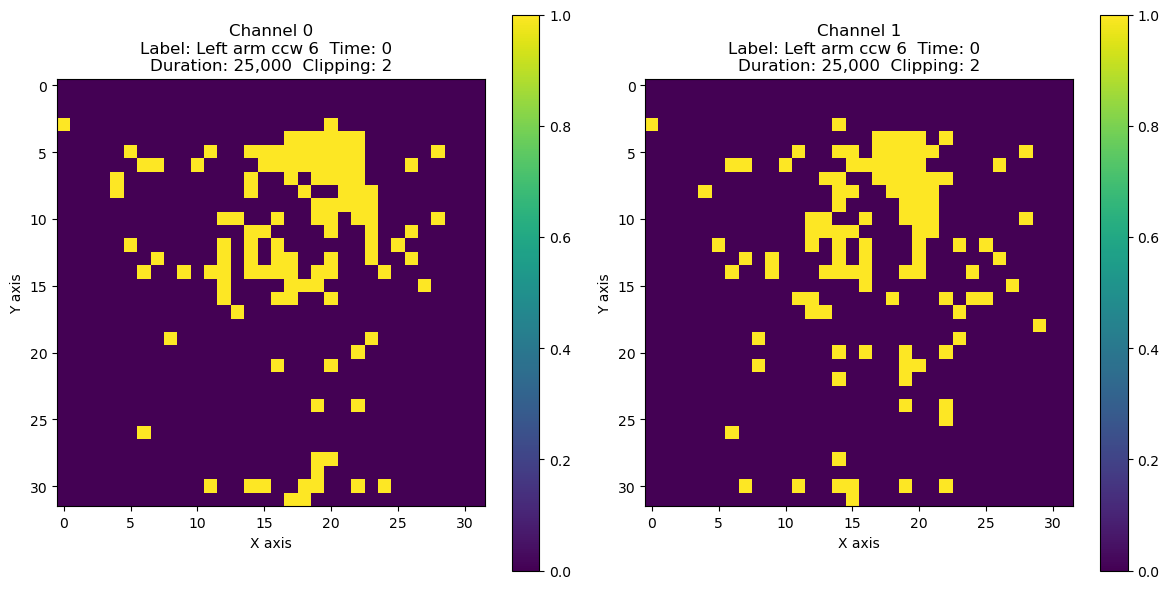

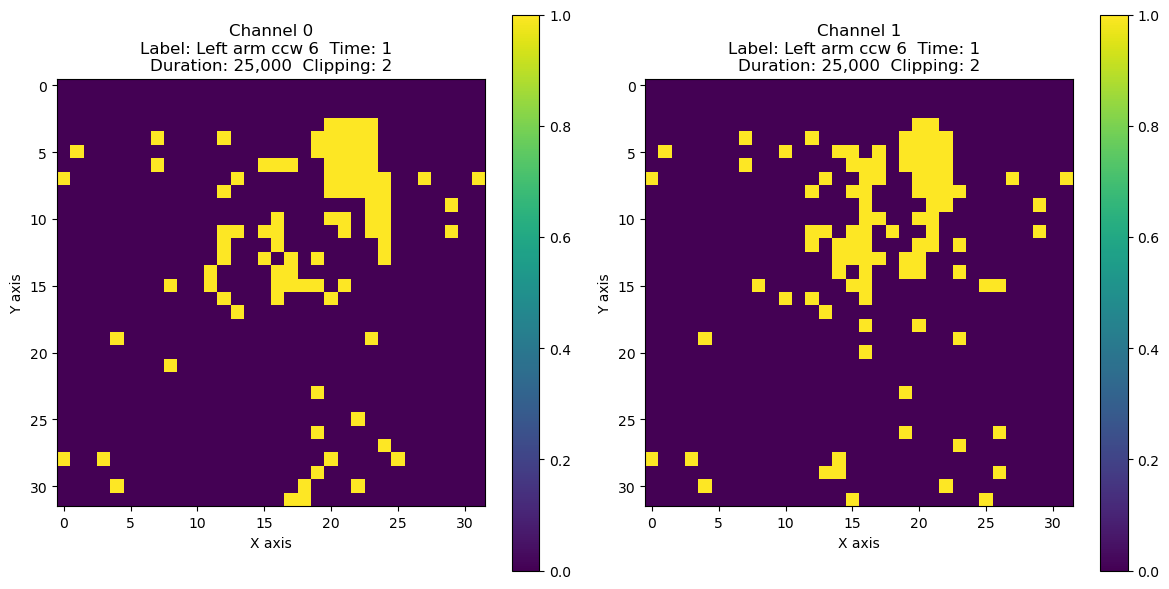

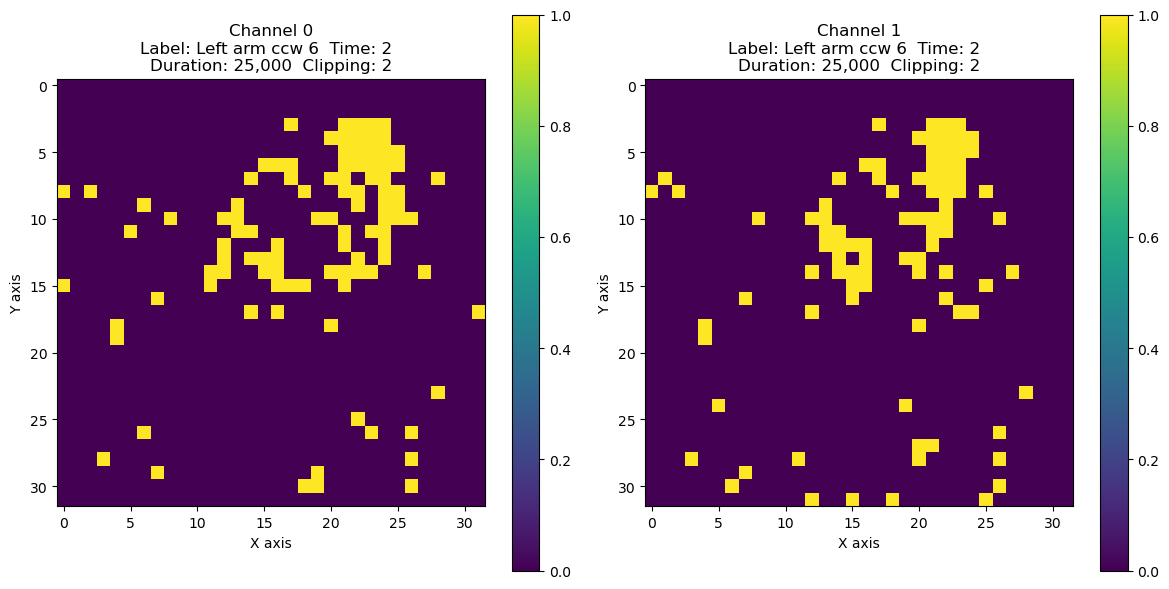

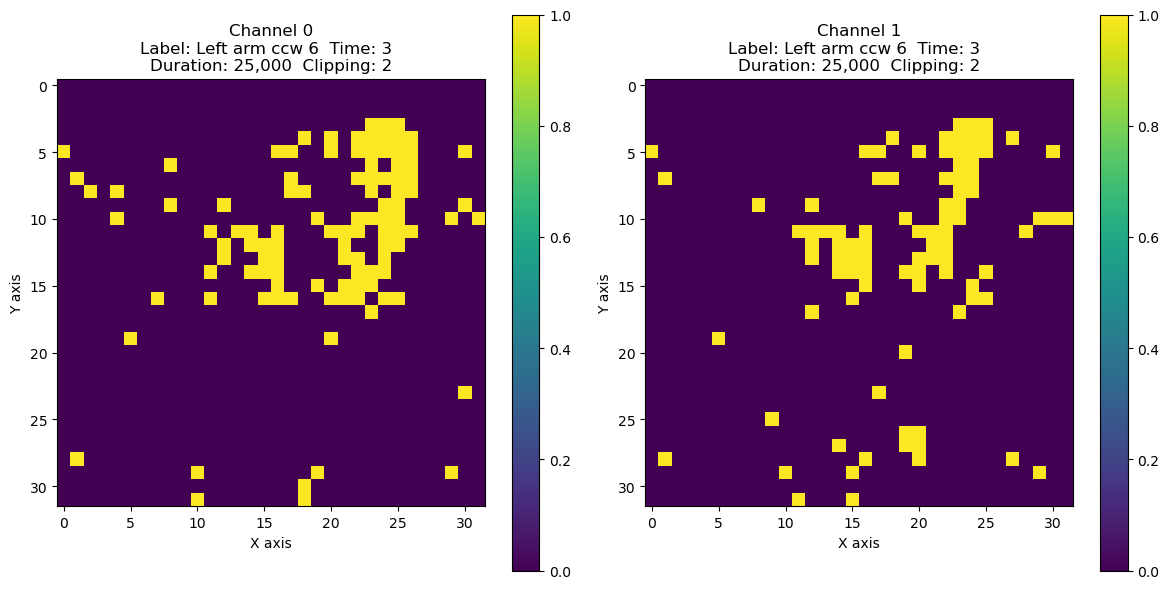

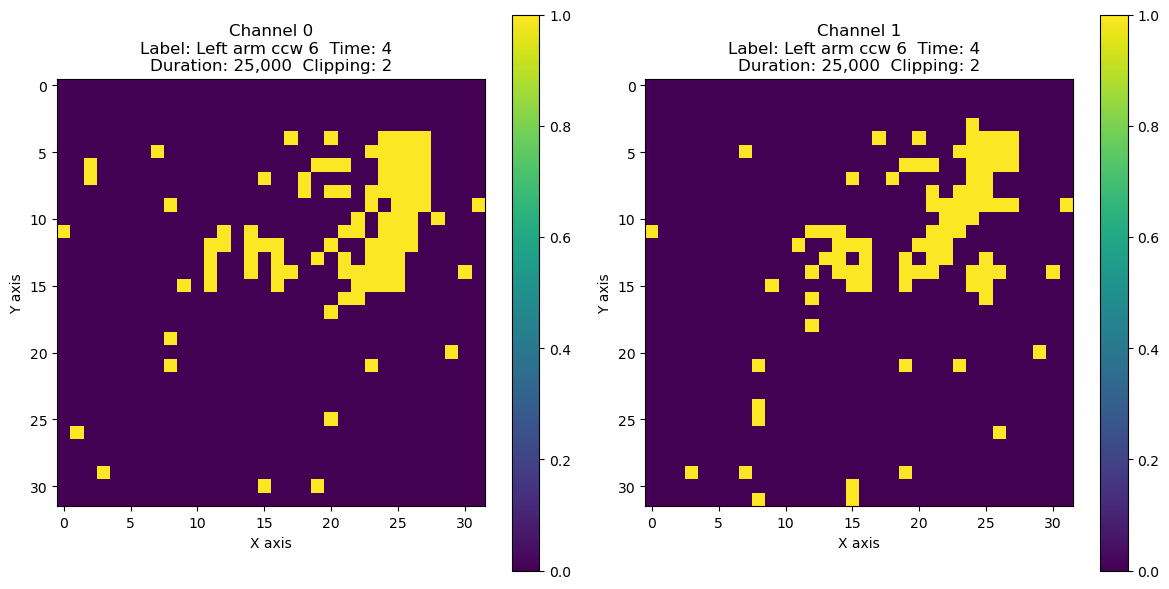

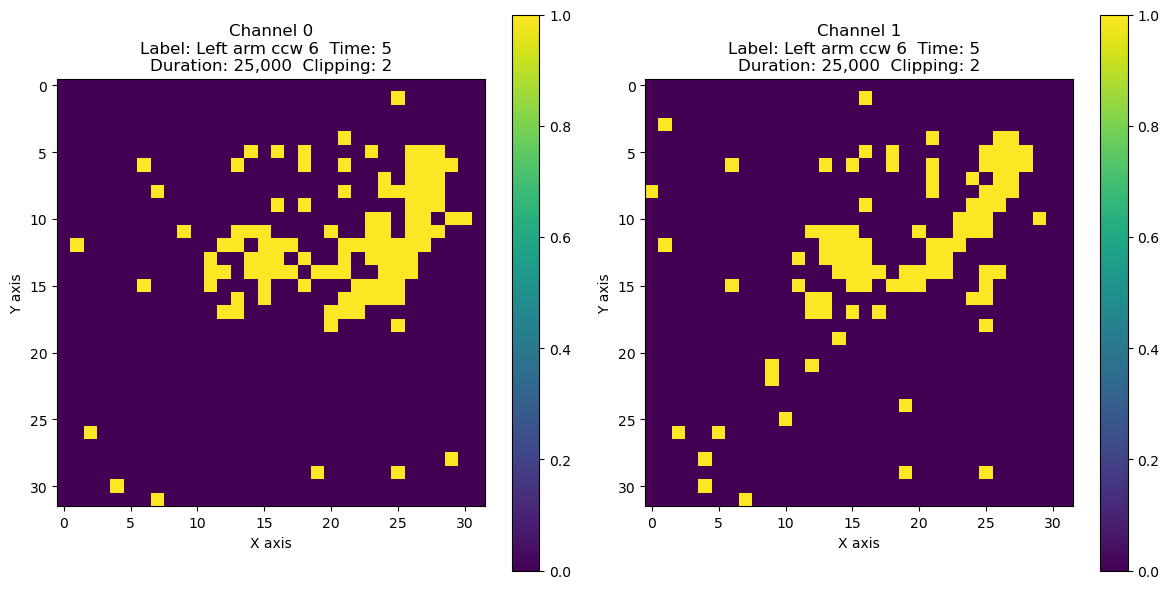

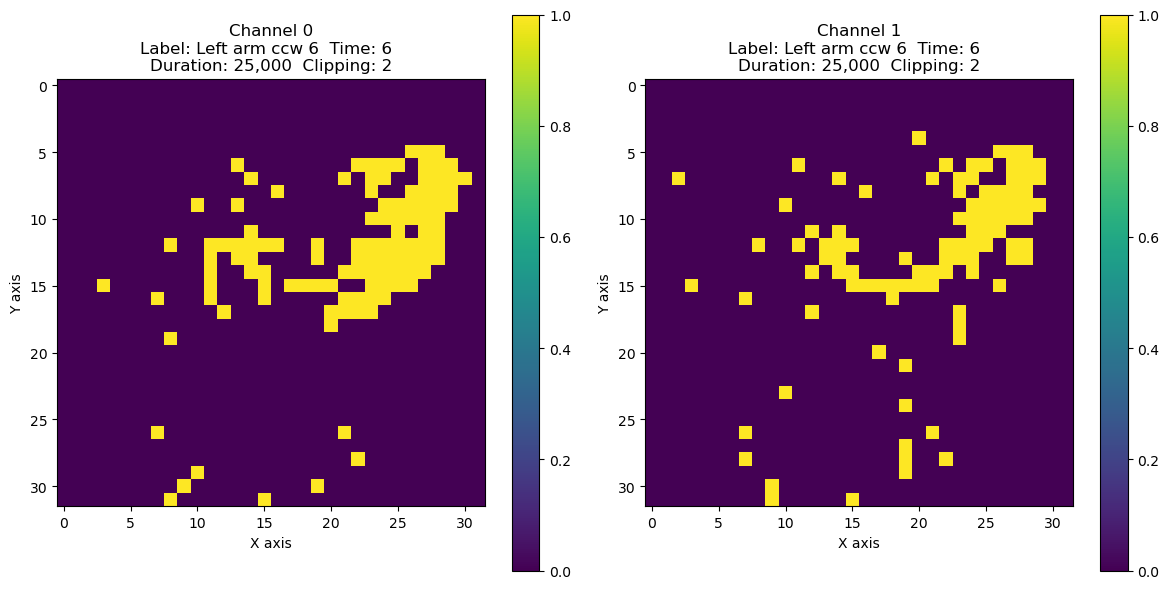

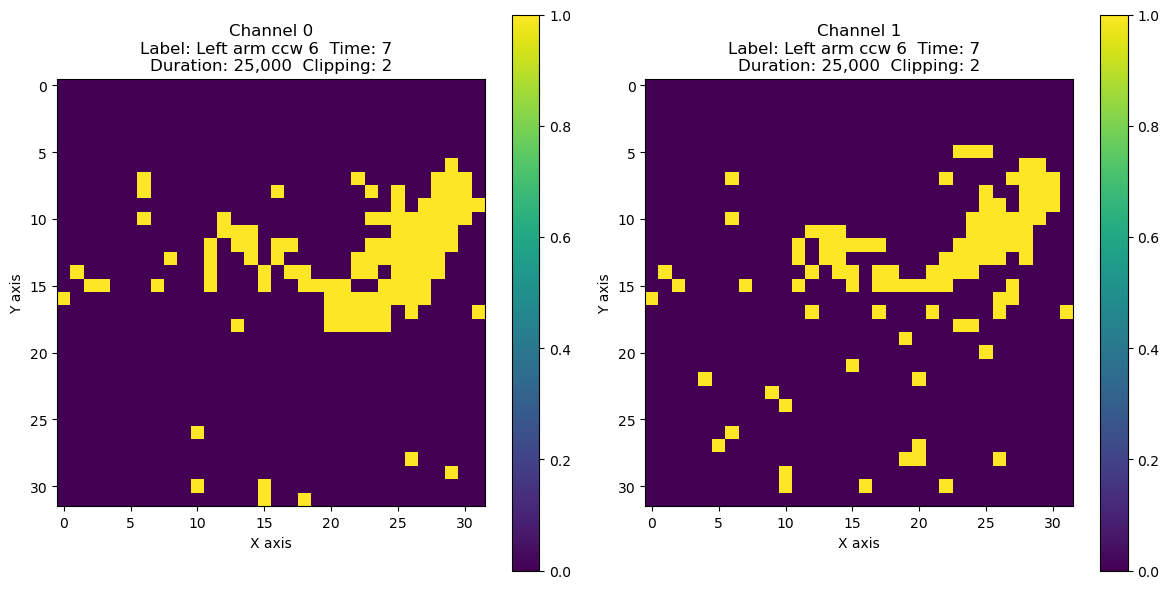

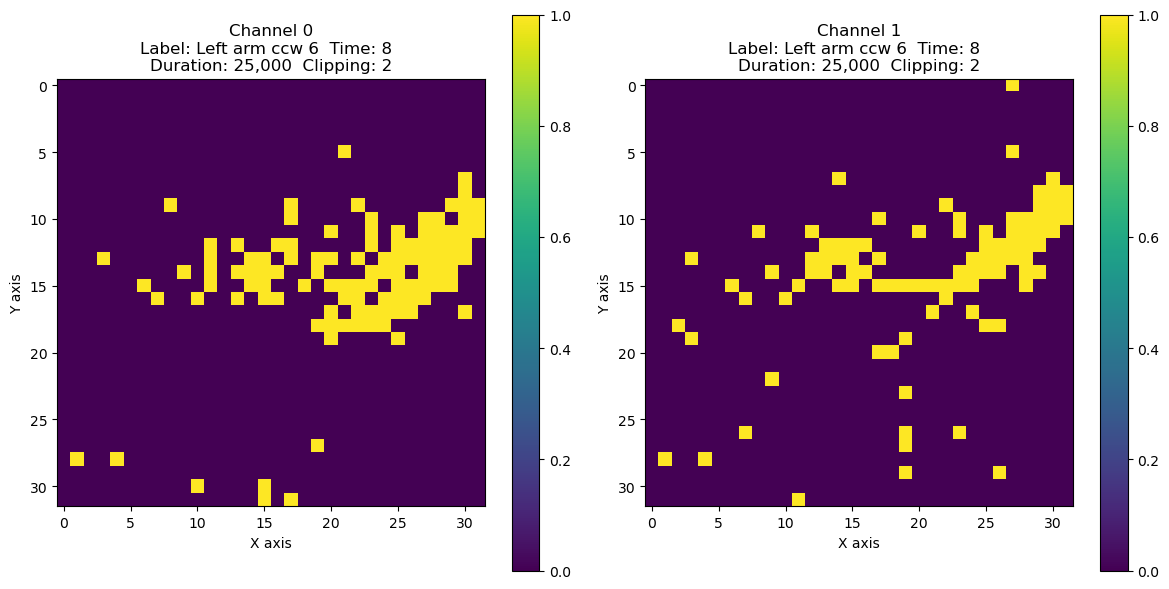

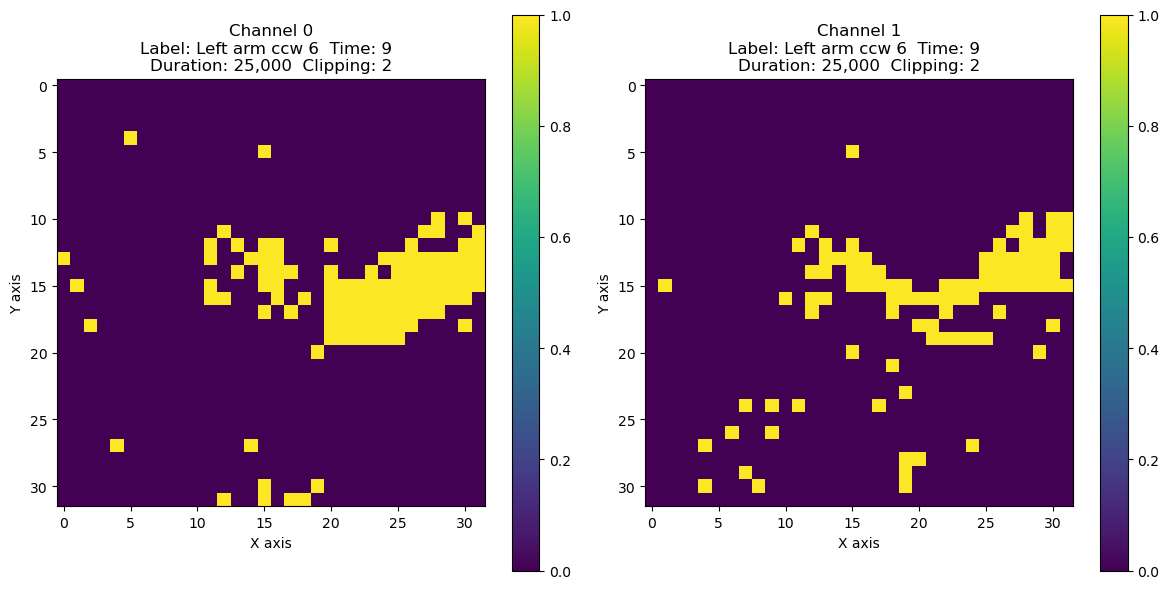

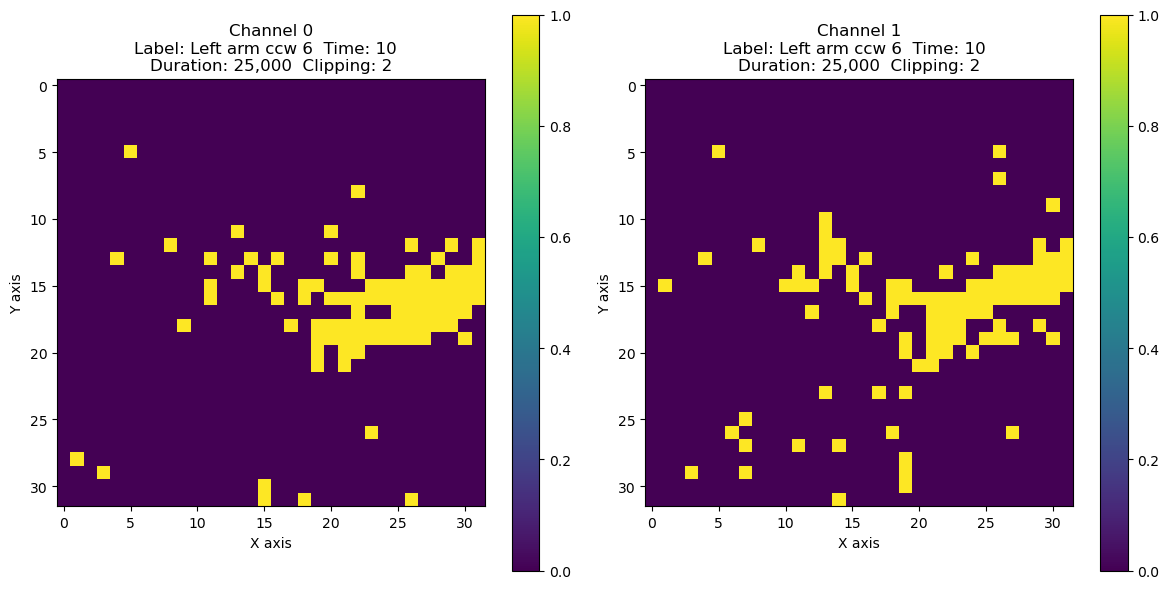

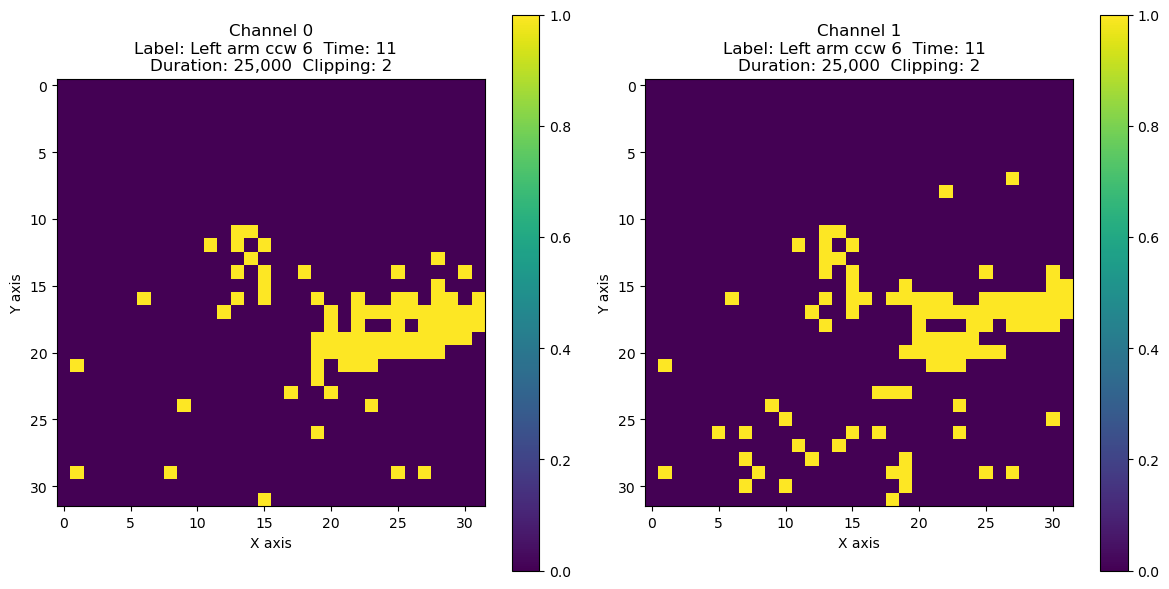

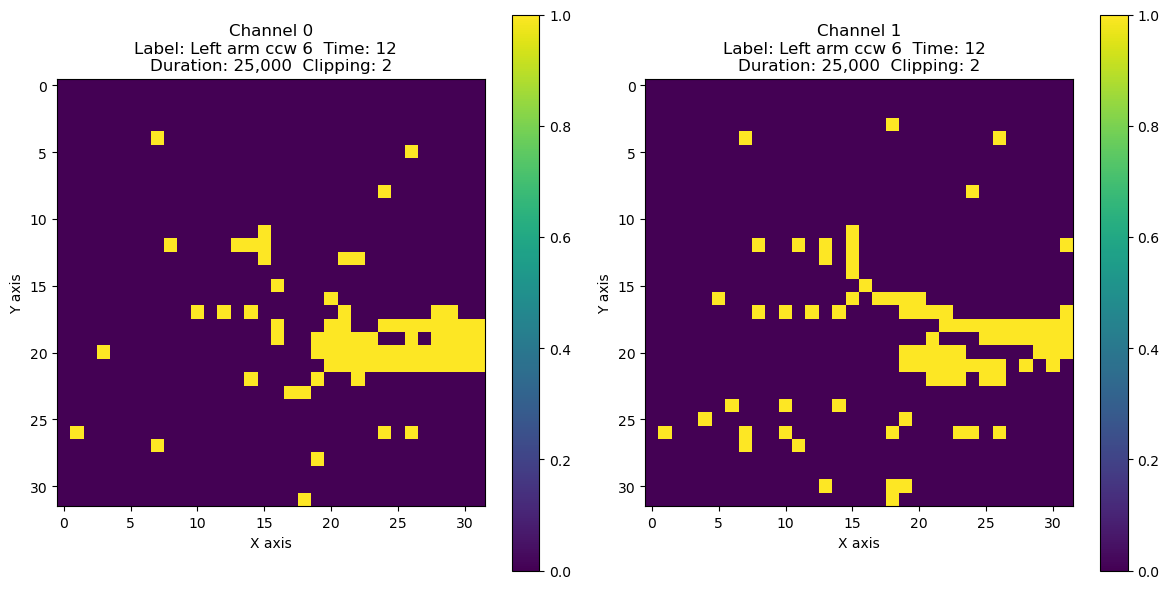

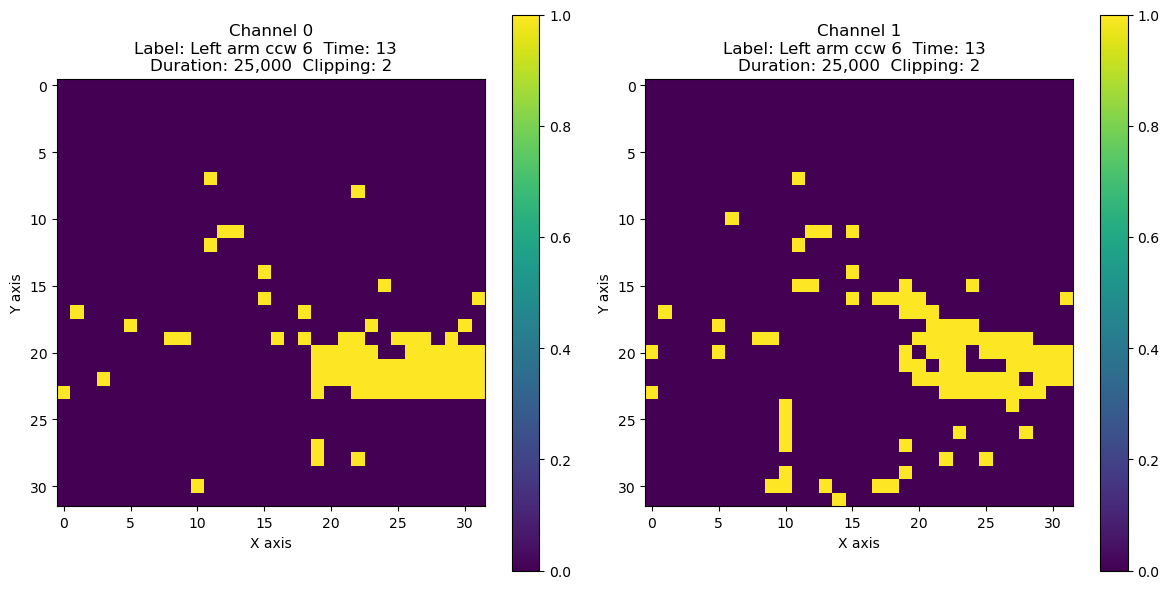

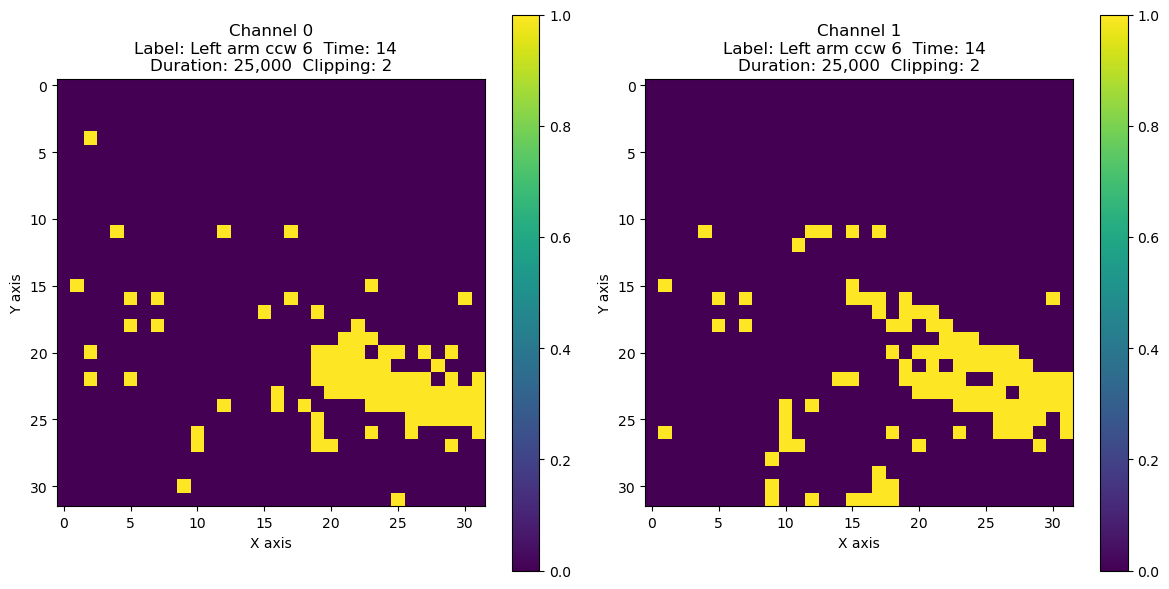

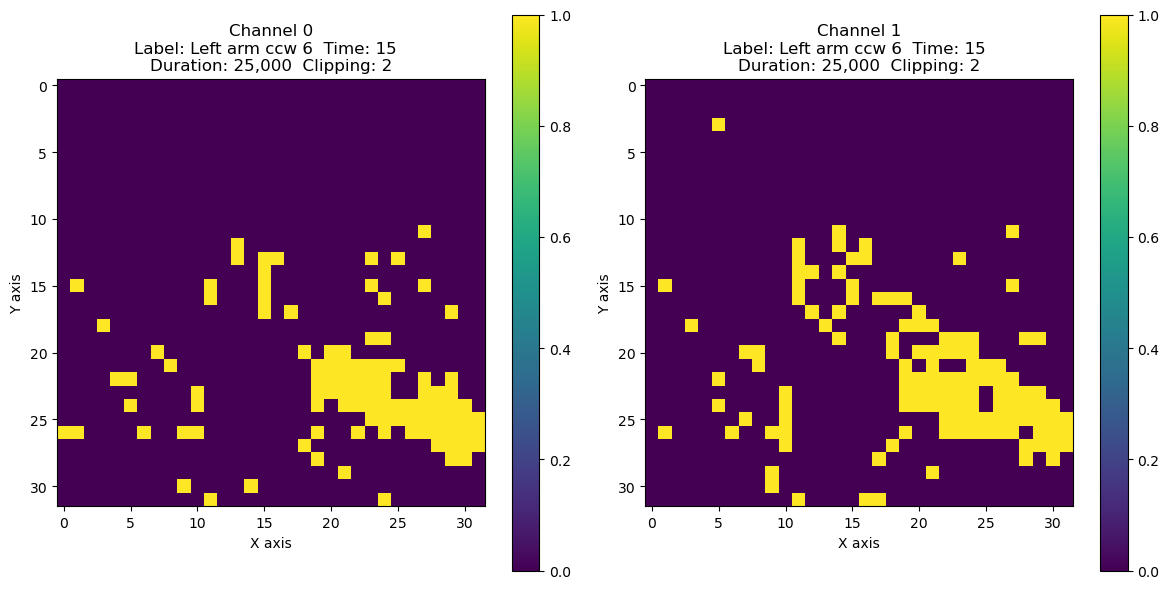

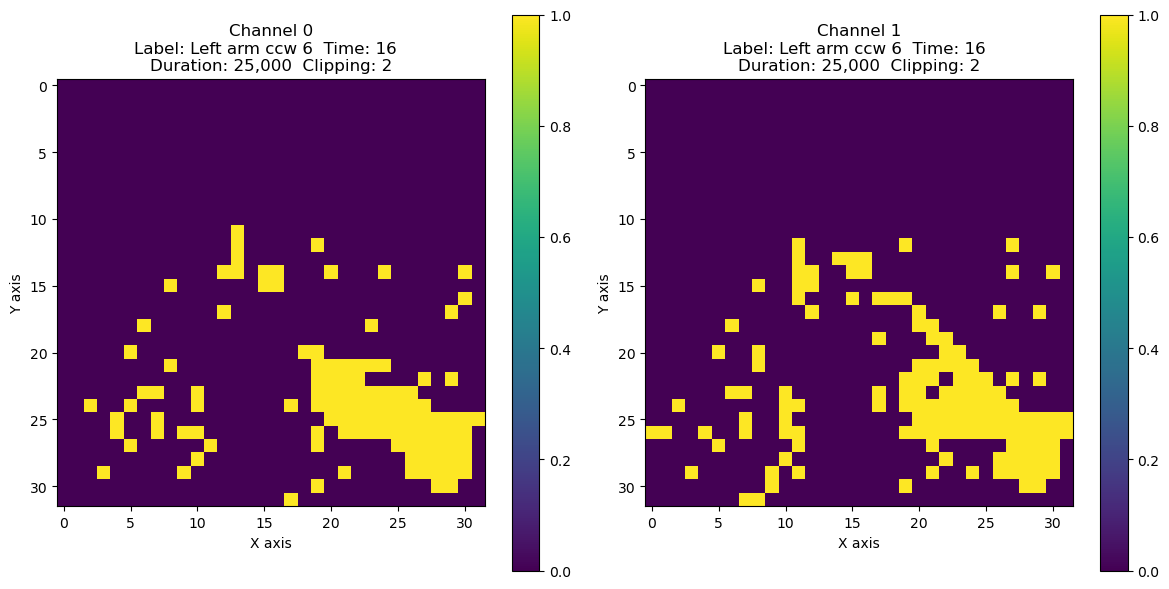

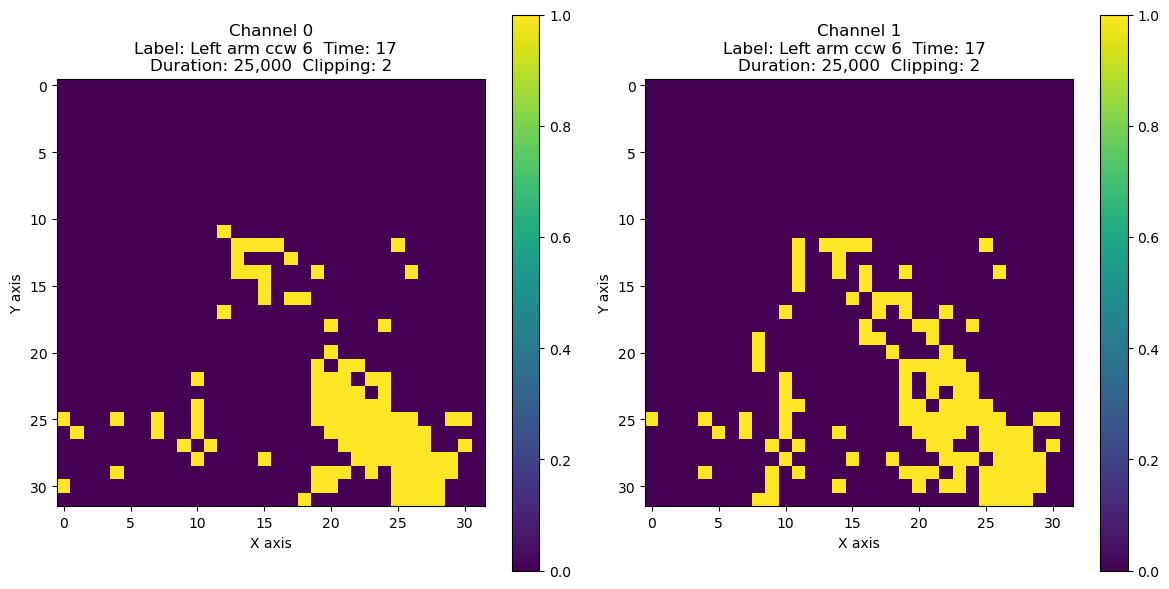

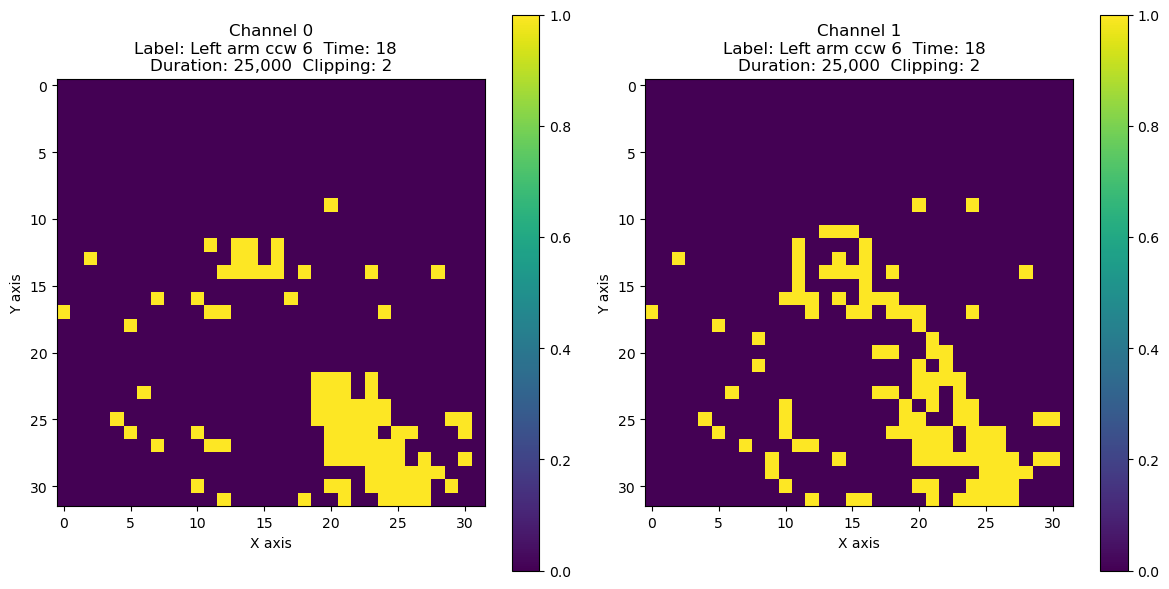

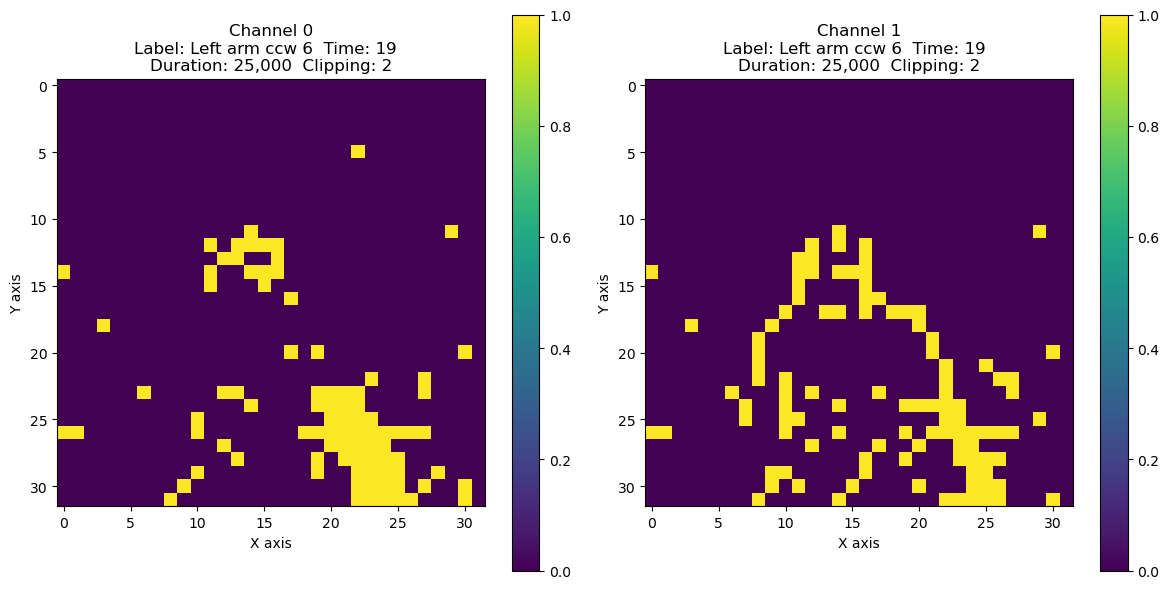

In [10]:
dvs_visualization(img, label, img.size(1), img.size(0), 42, duration, clipping)